In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from ast import literal_eval
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
patient_notes = pd.read_csv("../input/nbme-score-clinical-patient-notes/patient_notes.csv")
features = pd.read_csv("../input/nbme-score-clinical-patient-notes/features.csv")

train_data = pd.read_csv("../input/nbme-score-clinical-patient-notes/train.csv")

# patients_notes

In [3]:
print(patient_notes.shape)
patient_notes.sample(2)

(42146, 3)


,pn_num,case_num,pn_history
35543,82869,8,67 yo F presenting with trouble sleeping for 3...
1725,1864,0,17 yr old male with CC of heart pounding that ...


In [4]:
# pn_num - A unique identifier for each patient note.
patient_notes.pn_num.nunique()

42146

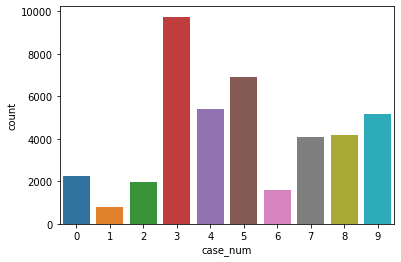

In [5]:
# case_num - A unique identifier for the clinical case a patient note represents.
sns.countplot(patient_notes.case_num);

In [6]:
patient_notes[patient_notes.pn_history.apply(lambda x: len(str(x)) < 31)]

,pn_num,case_num,pn_history
40711,93847,9,Patient wa s20 yo F c/o neck s


In [7]:
patient_notes.pn_history[40711]

'Patient wa s20 yo F c/o neck s'

# features

In [8]:
print(features.shape)
features.sample(2)

(143, 3)


,feature_num,case_num,feature_text
123,815,8,Early-wakening
71,502,5,No-caffeine-use


In [9]:
# feature_num - A unique identifier for each feature.
features.feature_num.nunique()

143

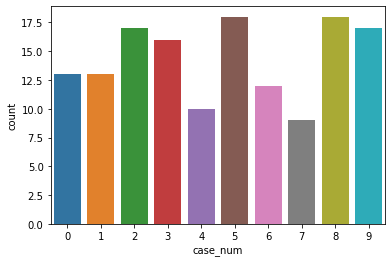

In [10]:
# case_num - A unique identifier for each case.
sns.countplot(features.case_num);

In [11]:
# feature_text - A description of the feature.
features.feature_text[2]

'Chest-pressure'

# train_data

In [12]:
print(train_data.shape)
train_data.sample(2)

(14300, 6)


,id,case_num,pn_num,feature_num,annotation,location
2620,20040_203,2,20040,203,['sexually active'],['787 802']
10445,72549_705,7,72549,705,[],[]


In [13]:
train_data.nunique()

id             14300
case_num          10
pn_num          1000
feature_num      143
annotation      5201
location        7534
dtype: int64

* pn_num - The patient note annotated in this row
* id - Unique identifier for each patient note / feature pair.
* pn_num - The patient note annotated in this row.
* feature_num - The feature annotated in this row.
* case_num - The case to which this patient note belongs.
* annotation - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
* location - Character spans indicating the location of each annotation within the note.

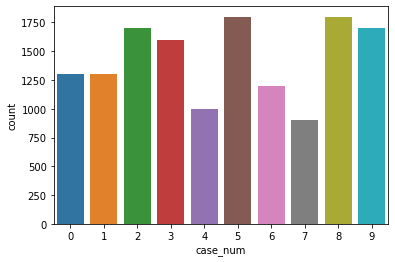

In [14]:
sns.countplot(train_data.case_num);

# Example train_data

In [15]:
samples_with_annotation = train_data[train_data.annotation.str.len() > 2].shape[0]
samples_without_annotation = train_data[train_data.annotation.str.len() == 2].shape[0]
all_samples = train_data.shape[0]
assert samples_with_annotation + samples_without_annotation == all_samples

samples_with_annotation, samples_without_annotation

(9901, 4399)

In [16]:
train_data[train_data.annotation.str.len() > 2]

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
...,...,...,...,...,...,...
14291,95333_908,9,95333,908,['Nausea'],['354 360']
14293,95333_910,9,95333,910,['lives with roomate'],['576 594']
14297,95333_914,9,95333,914,['photobia'],['274 282']
14298,95333_915,9,95333,915,['no sick contacts'],['421 437']


In [17]:
example = pd.merge(pd.merge(train_data.query('id == "00016_004"'), patient_notes, on=['case_num', 'pn_num']),
         features,
         on=['feature_num', 'case_num']
        )
example

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
0,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],HPI: 17yo M presents with palpitations. Patien...,Lightheaded


In [18]:
def get_loc_ind(loc:str) -> list:
    array = re.findall(r'\[(.*?)\]', loc)[0].replace("'", "").split()
    if array:
        return list(map(int, array))
    return 0, 0

In [19]:
strart_index, end_index = get_loc_ind(example['location'].values[0])

In [20]:
example.pn_history.values[0][strart_index : end_index]

'felt as if he were going to pass out'

In [21]:
train_data.query('case_num == 0 & feature_num == 4')['annotation'].value_counts()

[]                                          50
['lightheadedness']                         14
['light headedness']                         8
['lightheaded']                              8
['light headed']                             3
['light-headedness']                         2
['lightheadness']                            2
['felt like almost passed out']              1
['felt that he was going to pass out']       1
['presyncopal']                              1
['LIGHTHEADEDNESS']                          1
['dizziness']                                1
['presyncope']                               1
['felt as if he were going to pass out']     1
['felt lightheaded']                         1
['lighheadeness']                            1
['felt like passing out']                    1
['light-headed']                             1
['thought he would passout']                 1
['felt ike he was going to "pass out"']      1
Name: annotation, dtype: int64

# Preprocessing

In [22]:
train_data.location[0]

"['696 724']"

In [23]:
train_data.annotation[0]

"['dad with recent heart attcak']"

In [24]:
train_data['annotation'] = train_data.annotation.apply(literal_eval)
train_data['location'] = train_data.location.apply(literal_eval)

train_data.location[0]

['696 724']

In [25]:
train_data.annotation[0]

['dad with recent heart attcak']

In [26]:
train_merge = pd.merge(train_data.merge(patient_notes, on=['case_num', 'pn_num']),
                                        features,
                                        on=['feature_num', 'case_num']
                                        )
assert train_merge.shape[0] == train_data.shape[0]

print(train_merge.shape)
train_merge.sample(3)

(14300, 8)


,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
10945,81900_801,8,81900,801,"[3WKS, STARTED AFTER SHE LOST HER SON]",[41 77],"HPI:67 YO F C/O DIFFICULTY IN SLEEPING X 3WKS,...",Son-died-3-weeks-ago
7338,52923_504,5,52923,504,"[PALPITATION, PALPITATION, PALPITATION]","[13 24, 61 72, 120 131]","26 YO F WITH PALPITATION , THER IS NOO THING ...",Episodes-of-heart-racing
8402,50375_515,5,50375,515,[],[],Edie Whelan is a 26 year old female who presen...,Fatigue-OR-Difficulty-concentrating


In [27]:
train_merge["feature_text"] = train_merge["feature_text"].apply(lambda x: x.lower())
train_merge["pn_history"] = train_merge["pn_history"].apply(lambda x: x.lower())
train_merge.sample(3)

,id,case_num,pn_num,feature_num,annotation,location,pn_history,feature_text
4852,34918_305,3,34918,305,[],[],35 y/o m complains of worsening epigastric pai...,post-prandial-bloating-or-fullness-with-meals
12898,95330_902,9,95330,902,[yesterday],[183 192],ms. madden is a 20 yo female presenting w/ the...,1-day-duration-or-2-days-duration
9828,60506_611,6,60506,611,[8/10],[215 219],"a 17-year-old male, has come to the outpatient...",sharp-or-stabbing-or-7-to-8-out-of-10-on-pain-...


In [28]:
def prepare_input(tokenizer, text, feature_text):
    inputs = tokenizer(text, feature_text, 
                        max_length=416,
                        padding="max_length")
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

# Feature Words

In [29]:
feature_set = set()
for n, row in features.iterrows():
    tmp_set = set(row['feature_text'].split('-'))
    feature_set = feature_set | tmp_set
    
feature_set = {item.lower() for item in feature_set}
len(feature_set)

271

# Tokenizer
* ## Bert
* ## RoBerta_Large
* ## PubMedBert

In [30]:
tokenizers = ["bert-base-uncased",
              'roberta-large',
              "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"]

In [31]:
def token(tokenizer, feature_set):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer)
    
    voc_size_model = tokenizer.vocab_size
    print(voc_size_model)
    
    voc = np.array(list(tokenizer.get_vocab().keys()))
    voc = set(voc)
    voc = {item.lower() for item in voc}
    
    diff = feature_set - voc
    print(len(diff))
    
    return voc_size_model, voc, len(diff)

# Compare

In [32]:
res = []
for tok in tqdm(tokenizers):
    res.append(token(tok,feature_set))

assert len(res) == len(tokenizers)

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.98s/it]

30522
61


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

 67%|██████▋   | 2/3 [00:30<00:15, 15.48s/it]

50265
147


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/220k [00:00<?, ?B/s]

100%|██████████| 3/3 [00:43<00:00, 14.53s/it]

28895
47


In [33]:
voc_size_berta, voc_size_roberta, voc_size_pubmedbert = res[0][0], res[1][0], res[2][0]

undetected = np.array([res[0][-1], res[1][-1], res[2][-1]]) / len(feature_set) * 100

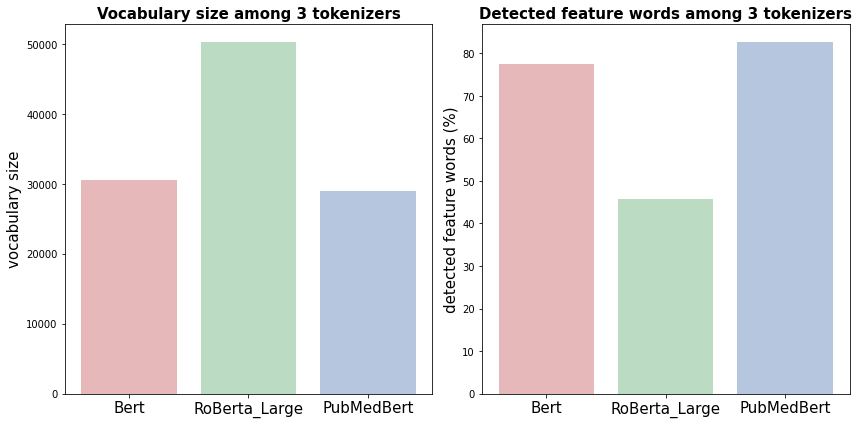

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
labels = ['Bert', 'RoBerta_Large', 'PubMedBert']

axes[0].bar([1,2,3], [voc_size_berta, voc_size_roberta, voc_size_pubmedbert],
           tick_label=labels, color=['#E7B8B9', '#BBDCC2', '#B7C6DF'])
axes[0].set_ylabel('vocabulary size', fontsize=15)
axes[0].set_title('Vocabulary size among 3 tokenizers', fontsize=15, fontweight='bold')
axes[0].tick_params(axis='x', labelsize=15)
axes[1].bar([1,2,3], 100 - undetected, tick_label=labels, color=['#E7B8B9', '#BBDCC2', '#B7C6DF'])
axes[1].set_ylabel('detected feature words (%)', fontsize=15)
axes[1].set_title('Detected feature words among 3 tokenizers', fontsize=15, fontweight='bold')
axes[1].tick_params(axis='x', labelsize=15)
fig.tight_layout()
plt.show()

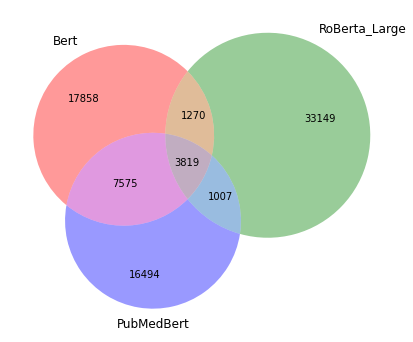

In [35]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

labels = ['Bert', 'RoBerta_Large', 'PubMedBert']

venn3([res[0][1], res[1][1], res[2][1]], set_labels=labels, ax=ax)
fig.tight_layout()
plt.show()

# Conclusion
* PubMedBert has the least vocabularies, but detects the most technical terms;
* PubMedBert can be much effective to biomedical notes because of having much technical terms;
* But since PubMedBert has less vocabularies, it can be poor at catching the whole text meanings.